In [ ]:
#补充不区分drought的paired sites
#有象区&无象区
#其他paired site结果见py_v4_01_forest-structure_240501

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

# data prepare 

In [26]:
#有象区&无象区
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
dt=np.ones((6500,7900))
non_ele=dt-ele
ele=ele.astype(np.float32)
ele[ele==0]=np.nan
non_ele=non_ele.astype(np.float32)
non_ele[non_ele==0]=np.nan

In [11]:
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
print("treeH:",treeH.min(),treeH.max())
th_Lang=read_img(drv_path+'Lang_TH_2019_001_sub.tif')[0]
print("th_Lange:",th_Lang.min(),th_Lang.max())
tc_planet = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]
print("tc_planet:",tc_planet.min(),tc_planet.max())
tc_Hansen10=read_img(drv_path+'Hansen_TC_2010_001_afr.tif')[0]
print("tc_Hansen10:",tc_Hansen10.min(),tc_Hansen10.max())
treeH[treeH==0]=np.nan
th_Lang=th_Lang.astype(np.float32)
th_Lang[th_Lang>100]=np.nan
tc_planet=tc_planet.astype(np.float32)
tc_planet[tc_planet==0]=np.nan
tc_planet[tc_planet>100]=np.nan
tc_Hansen10=tc_Hansen10.astype(np.float32)
tc_Hansen10[tc_Hansen10==0]=np.nan

treeH: 0.0 37.440773
th_Lange: 0 103
tc_planet: 0 216
tc_Hansen10: 0 100


In [12]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [13]:
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

# Forest structure differ

## slide window

In [27]:
"""
2023/11/25
supply paired sites methods.
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool=[ele*mask,non_ele*mask]
res_pool=[treeH,th_Lang,tc_planet,tc_Hansen10,dem,slope] #protect need conver to fraction
dist_name=['ele_area','nonele_area']
res_name=['treeH','th_Lang','tc_planet','tc_Hansen10','dem','slope']

# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(2):
    for j in range(6):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Forest-structure_{}_{}_0.25deg_240504.npy'.format(dist_name[i],res_name[j]))
aa_name

['Forest-structure_ele_area_treeH_0.25deg_240504.npy',
 'Forest-structure_ele_area_th_Lang_0.25deg_240504.npy',
 'Forest-structure_ele_area_tc_planet_0.25deg_240504.npy',
 'Forest-structure_ele_area_tc_Hansen10_0.25deg_240504.npy',
 'Forest-structure_ele_area_dem_0.25deg_240504.npy',
 'Forest-structure_ele_area_slope_0.25deg_240504.npy',
 'Forest-structure_nonele_area_treeH_0.25deg_240504.npy',
 'Forest-structure_nonele_area_th_Lang_0.25deg_240504.npy',
 'Forest-structure_nonele_area_tc_planet_0.25deg_240504.npy',
 'Forest-structure_nonele_area_tc_Hansen10_0.25deg_240504.npy',
 'Forest-structure_nonele_area_dem_0.25deg_240504.npy',
 'Forest-structure_nonele_area_slope_0.25deg_240504.npy']

In [28]:
for i in range(12):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (42744)...
执行任务1 (42744)...
执行任务2 (42744)...
执行任务3 (42744)...
执行任务4 (42744)...
执行任务5 (42744)...
执行任务6 (42744)...
执行任务7 (42744)...
执行任务8 (42744)...
执行任务9 (42744)...
执行任务10 (42744)...
执行任务11 (42744)...


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 成对样点求Δ

### ele & non-ele 
delta1,tree_delta1,pp_value1

In [2]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_ele_area_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_nonele_area_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_ele_area_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_nonele_area_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [3]:
res_name=['treeH','tc_planet']
delta1=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_ele_area_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_nonele_area_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta1.append(ff)
delta1[0].shape

(260, 316)

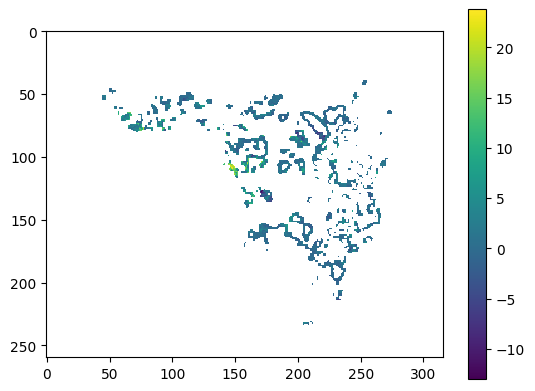

In [4]:
plt.imshow(delta1[0])
plt.colorbar()

In [5]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

tree_delta1=[]
for i in range(2):
    tree_delta1.append(kill_nan(delta1[i]))

In [6]:
len(tree_delta1[0]),len(tree_delta1[1])

(6039, 6650)

In [7]:
#计算标准误方法2
#res_name=['treeH','th_Lang','tc_planet','tc_Hansen10','Bio']
se=[]
for i in range(2):
    se.append(stats.sem(tree_delta1[i]))
se

[0.047130402970519215, 0.1799303679530555]

In [8]:
mean=[]
for i in range(2):
    mean.append(np.mean(tree_delta1[i]))
mean

[1.320365222645015, 4.025662357681676]

In [9]:
pp_value1=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(drv_path+'Forest-structure_ele_area_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_nonele_area_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value1.append(p)
pp_value1 #p value of ndvi_res and csif_res

[1.7052386122155815e-167, 8.57954801856716e-101]

### drought_ele & drought_nonele
delta2,tree_delta2,pp_value2

In [10]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_DEAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_DEAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [11]:
res_name=['treeH','tc_planet']
delta2=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_DEAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta2.append(ff)
delta2[0].shape

(260, 316)

In [12]:
tree_delta2=[]
for i in range(2):
    tree_delta2.append(kill_nan(delta2[i]))

In [13]:
len(tree_delta2[0]),len(tree_delta2[1])

(2742, 2843)

In [14]:
#计算标准误方法2
#res_name=['treeH','th_Lang','tc_planet','tc_Hansen10','Bio']
se=[]
for i in range(2):
    se.append(stats.sem(tree_delta2[i]))
se

[0.07329907861015815, 0.25988301886130194]

In [15]:
mean=[]
for i in range(2):
    mean.append(np.mean(tree_delta2[i]))
mean

[1.19321574120192, 3.3922385460802924]

In [16]:
pp_value2=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(drv_path+'Forest-structure_DEAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value2.append(p)
pp_value2 #p value of ndvi_res and csif_res

[1.5373062313248024e-57, 1.0680559379169923e-31]

### nondrought_ele & nondrougth_nonele
delta3,tree_delta3,pp_value3

In [17]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_Ndro_ele_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_Ndro_Nele_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_Ndro_ele_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_Ndro_Nele_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [18]:
res_name=['treeH','tc_planet']
delta3=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_Ndro_ele_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_Ndro_Nele_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta3.append(ff)
delta3[0].shape

(260, 316)

In [19]:
tree_delta3=[]
for i in range(2):
    tree_delta3.append(kill_nan(delta3[i]))

In [20]:
len(tree_delta3[0])

3368

In [21]:
#计算标准误方法2
#res_name=['treeH','th_Lang','tc_planet','tc_Hansen10','Bio']
se=[]
for i in range(2):
    se.append(stats.sem(tree_delta3[i]))
se

[0.05936989206137423, 0.251438057380351]

In [22]:
mean=[]
for i in range(2):
    mean.append(np.mean(tree_delta3[i]))
mean

[0.977785104062771, 3.4587390169131855]

In [23]:
pp_value3=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_Ndro_ele_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_Ndro_Nele_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value3.append(p)
pp_value3 #p value of ndvi_res and csif_res

[2.270235791997656e-65, 4.694117235035782e-37]

## Fig.1

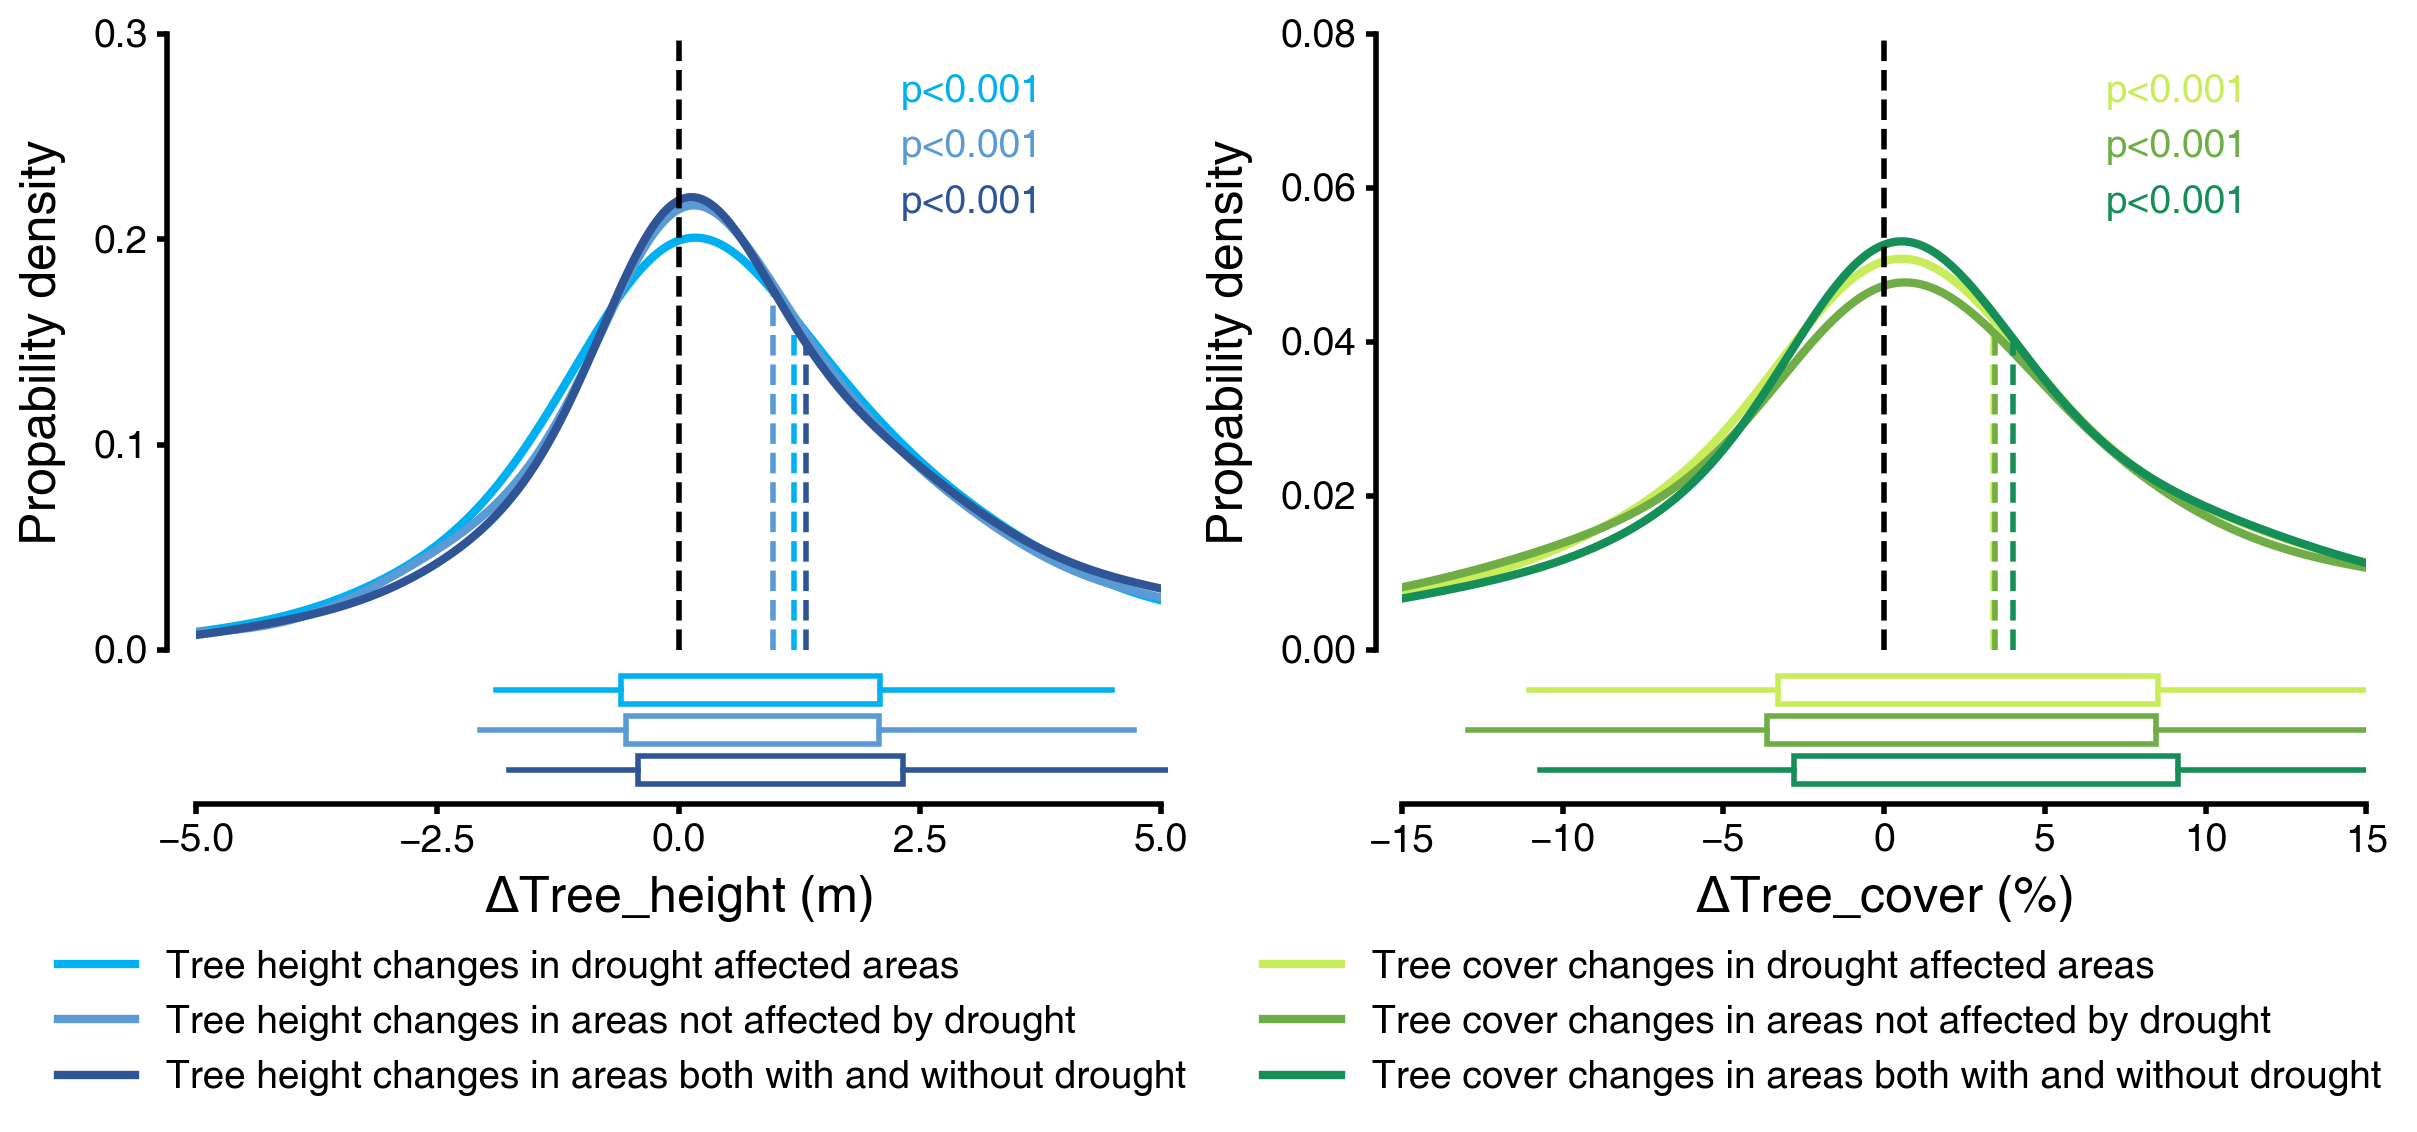

In [35]:
###### drought_ele & drought_nonele, nondrought_ele & nondrougth_nonele, ele & non-ele
#tree_delta2,tree_delta3,tree_delta1
#['treeH','th_Lange','tc_planet','tc_Hansen10']
#只用['treeH','tc_planet']

data_th=[tree_delta2[0],tree_delta3[0],tree_delta1[0]]
data_pp_th=[pp_value2[0],pp_value3[0],pp_value1[0]]
data_tc=[tree_delta2[1],tree_delta3[1],tree_delta1[1]]
data_pp_tc=[pp_value2[1],pp_value3[1],pp_value1[1]]

data=[data_th,data_tc]
pp=[data_pp_th,data_pp_tc]

import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(14,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.2)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = np.array([(0,176,240),(91,155,213),(47,85,151)])
cl2 = np.array([(201,236,90),(112,173,71),(22,142,88)])
cl=[cl1/255,cl2/255]
#cl=['C0','salmon']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label1=['Tree height changes in drought affected areas', 'Tree height changes in areas not affected by drought',
        'Tree height changes in areas both with and without drought']
label2=['Tree cover changes in drought affected areas', 'Tree cover changes in areas not affected by drought',
        'Tree cover changes in areas both with and without drought']
label=[label1,label2]
tx=['(m)','(%)']
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    for j in range(3):
        x=np.linspace(-15,15,1000)
        mean=np.nanmean(data[i][j])
        delta_rav=gc.nanravel(data[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        ax.plot(x,z,lw=3,color=cl[i][j],label=label[i][j])
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i][j])
        if pp[i][j]<0.001:
            #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
            ax.text(0.73,0.89-j*0.09, 'p<0.001'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.01:
            ax.text(0.63,0.89-j*0.1, '{:.2f} **'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.05:
            ax.text(0.63,0.89-j*0.1, '{:.2f} *'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        else:
            ax.text(0.63,0.89-j*0.1, '{:.3f} (p={:.2f})'.format(mean,data_pp[i]), fontsize=14,transform = ax.transAxes,color=cl[i][j])
    if i ==0:
        ax.vlines(0,0,0.3,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.3)
        ax.set_yticks(np.arange(0,0.31,0.1))
        ax.set_xlim(-5,5)
        ax.set_xticks(np.arange(-5,5.1,2.5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-5.3))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.075))
        ax.set_xlabel('$\Delta$Tree_height (m)',labelpad=5)        
    else:
        ax.vlines(0,0,0.08,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.08)
        ax.set_yticks(np.arange(0,0.081,0.02))
        ax.set_xlim(-15,15)
        ax.set_xticks(np.arange(-15,15.1,5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-15.8))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.020))
        ax.set_xlabel('$\Delta$Tree_cover (%)',labelpad=5)
    ax.legend(fontsize=14,loc=(-0.16,-0.75),frameon=False)
    #ax.legend(fontsize=14,loc='upper left',frameon=False,handlelength=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.set_xlim(-2,2)
    #ax.set_xticks(np.arange(-2,2,0.5))
    ax.set_ylabel('Propability density',labelpad=10)
    
    ax.xaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)

    ax.tick_params(labelsize=14)
    ax.yaxis.label.set_size(18)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    for j in range(3):
        if i ==0:
            if j ==0:
                ax1=fig.add_axes([0.122,-0,0.35,0.12])#左，底，宽，高
            elif j ==1:
                ax1=fig.add_axes([0.122,-0.05,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.122,-0.1,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-5,5)
            ax1.set_xticks(np.arange(-5,5,2.5))
        if i ==1:
            if j==0:
                ax1=fig.add_axes([0.55,-0,0.35,0.12])#左，底，宽，高
            elif j==1:
                ax1=fig.add_axes([0.55,-0.05,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.55,-0.1,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-15,15)
            ax1.set_xticks(np.arange(-15,15,5))
        ax1.axis('off')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
        #ax.spines['bottom'].set_visible(False)
        bplot=ax1.boxplot(data[i][j],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl[i][j],"markeredgecolor":cl[i][j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl[i][j],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl[i][j],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl[i][j]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i][j],'color':cl[i][j]})
                
            
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_c-d.tif", dpi=600, bbox_inches = 'tight')

# 区分LA－LC

In [121]:
LA=read_img(spei_path+'LA_extant_001_240320.tif')[0]
LA[LA>1]=1
LC=read_img(spei_path+'LC_extant_001_240320.tif')[0]
print("LA_da:",LA.min(),LA.max())
print("LC_da:",LC.min(),LC.max())

LA_da: 0.0 1.0
LC_da: 0.0 1.0


In [122]:
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
dt=np.ones((6500,7900))
non_ele=dt-ele
non_ele=non_ele.astype(np.float32)
non_ele[non_ele==0]=np.nan

LA[LA==0]=np.nan
LC[LC==0]=np.nan
non_ele[non_ele==0]=np.nan

In [137]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [138]:
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

## slide window

In [139]:
"""
2023/11/25
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool=[LA*mask,LC*mask,non_ele*mask]
res_pool=[treeH,tc_planet,dem,slope] #protect need conver to fraction
dist_name=['LA','LC','non_ele']
res_name=['treeH','tc_planet','dem','slope']

aa=[]
aa_name=[]
for i in range(3):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Forest-structure_{}_{}_0.25deg_240504.npy'.format(dist_name[i],res_name[j]))
aa_name

['Forest-structure_LA_treeH_0.25deg_240504.npy',
 'Forest-structure_LA_tc_planet_0.25deg_240504.npy',
 'Forest-structure_LA_dem_0.25deg_240504.npy',
 'Forest-structure_LA_slope_0.25deg_240504.npy',
 'Forest-structure_LC_treeH_0.25deg_240504.npy',
 'Forest-structure_LC_tc_planet_0.25deg_240504.npy',
 'Forest-structure_LC_dem_0.25deg_240504.npy',
 'Forest-structure_LC_slope_0.25deg_240504.npy',
 'Forest-structure_non_ele_treeH_0.25deg_240504.npy',
 'Forest-structure_non_ele_tc_planet_0.25deg_240504.npy',
 'Forest-structure_non_ele_dem_0.25deg_240504.npy',
 'Forest-structure_non_ele_slope_0.25deg_240504.npy']

In [140]:
for i in range(12):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (42744)...
执行任务1 (42744)...
执行任务2 (42744)...
执行任务3 (42744)...
执行任务4 (42744)...
执行任务5 (42744)...
执行任务6 (42744)...
执行任务7 (42744)...
执行任务8 (42744)...
执行任务9 (42744)...
执行任务10 (42744)...
执行任务11 (42744)...


## 成对样点求Δ

In [141]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
#------------LA-------------------
dem1=np.load(drv_path+'Forest-structure_LA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_non_ele_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_LA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_non_ele_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask_LA=np.ones((260,316))*dem_differ*slo_differ
#------------------LC--------------------
dem1=np.load(drv_path+'Forest-structure_LC_da_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_non_ele_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_LC_da_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_non_ele_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask_LC=np.ones((260,316))*dem_differ*slo_differ

In [148]:
dist_name=['LA','LC']
dd_mask=[dd_mask_LA,dd_mask_LC]
delta_TH=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_{}_treeH_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask[i]
    f2=np.load(drv_path+'Forest-structure_non_ele_treeH_0.25deg_240504.npy',allow_pickle=True)*dd_mask[i]
    ff=f1-f2
    delta_TH.append(ff)
    
delta_TC=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_{}_tc_planet_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask[i]
    f2=np.load(drv_path+'Forest-structure_non_ele_tc_planet_0.25deg_240504.npy',allow_pickle=True)*dd_mask[i]
    ff=f1-f2
    delta_TC.append(ff)
delta_TH[0].shape

(260, 316)

In [149]:
for i in range(2):
    print("count is",np.count_nonzero(~np.isnan(delta_TH[i])))
for i in range(2):
    print("count is",np.count_nonzero(~np.isnan(delta_TC[i])))

count is 3836
count is 1229
count is 4456
count is 1232


In [150]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

TH_delta=[]
TC_delta=[]
for i in range(2):
    TH_delta.append(kill_nan(delta_TH[i]))
    TC_delta.append(kill_nan(delta_TC[i]))

In [151]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta_TH=[]
p_delta_TC=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_{}_treeH_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask[i]
    f2=np.load(drv_path+'Forest-structure_non_ele_treeH_0.25deg_240504.npy',allow_pickle=True)*dd_mask[i]
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta_TH.append(p)
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_{}_tc_planet_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask[i]
    f2=np.load(drv_path+'Forest-structure_non_ele_tc_planet_0.25deg_240504.npy',allow_pickle=True)*dd_mask[i]
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta_TC.append(p)

p_delta_TH,p_delta_TC #p value of ndvi_res and csif_res

([2.819590750881276e-43, 2.2670812109538597e-84],
 [8.346068303227521e-42, 7.530261485974514e-38])

## fig_pdf

In [152]:
#计算标准误方法1
for i in range(2):
    dt=np.std(TH_delta[i])/np.sqrt(len(TH_delta[i]))
    print(dt)
for i in range(2):
    dt=np.std(TC_delta[i])/np.sqrt(len(TC_delta[i]))
    print(dt)

0.042623118371597955
0.13930623337845185
0.2279554385565178
0.3293192218283013


0.6255226423021899 [0.22327805]
2.490155035058496 [0.10813958]
3.3532777079238927 [0.03952865]
4.460294948382811 [0.04731021]


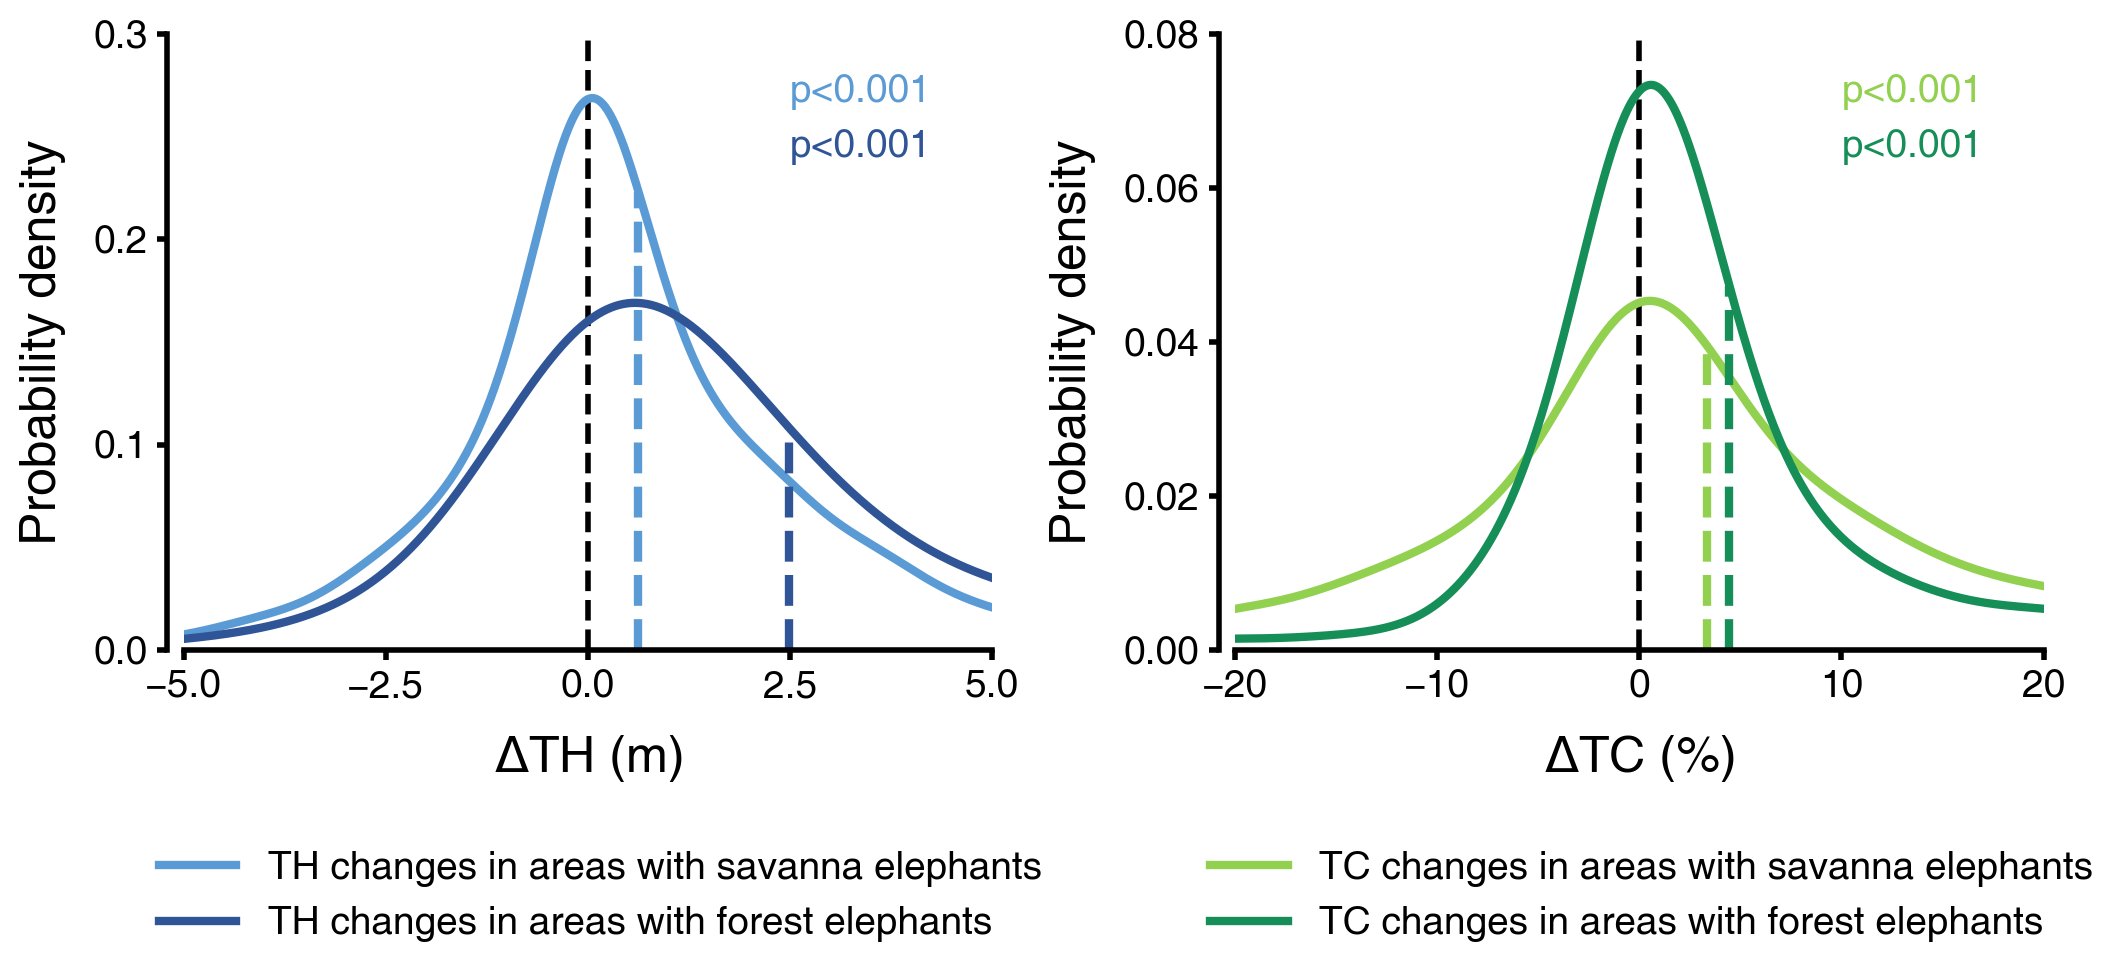

In [155]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt

data=[TH_delta,TC_delta]
pp=[p_delta_TH,p_delta_TC]

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.3,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl1 = np.array([(91,155,213),(47,85,151)])
cl2 = np.array([(146,208,80),(22,142,88)])
cl=[cl1/255,cl2/255]
tx=['(m)','(%)']
cl2=['C0','salmon']
#res_name=['TH','TC']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label_th=['TH changes in areas with savanna elephants','TH changes in areas with forest elephants']
label_tc=['TC changes in areas with savanna elephants','TC changes in areas with forest elephants']
label=[label_th,label_tc]

for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    if i ==0:
        x=np.linspace(-5,5,1000)
        ax.vlines(0,0,0.3,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.3)
        ax.set_yticks(np.arange(0,0.301,0.1))
        ax.set_xlim(-5,5)
        ax.set_xticks(np.arange(-5,5.1,2.5))
        ax.set_xlabel('$\Delta$TH (m)',labelpad=10)
    else:
        x=np.linspace(-20,20,1000)
        ax.vlines(0,0,0.08,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.08)
        ax.set_yticks(np.arange(0,0.0801,0.02))
        ax.set_xlim(-20,20)
        ax.set_xticks(np.arange(-20,20.1,10))
        ax.set_xlabel('$\Delta$TC (%)',labelpad=10)
    for j in range(2):
        mean=np.nanmean(data[i][j])
        delta_rav=gc.nanravel(data[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        ax.plot(x,z,lw=3,color=cl[i][j],label=label[i][j])
        ax.vlines(mean,0,z_mean,lw=3,ls='--',color=cl[i][j])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.legend(fontsize=12,loc='upper left',frameon=False)
        if pp[i][j]<0.001:
            ax.text(0.75,0.89-j*0.09, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.01:
            ax.text(0.75,0.89-j*0.09, 'p<0.01', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.05:
            ax.text(0.75,0.89-j*0.09, 'p<0.05', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        else:
            ax.text(0.75,0.89-j*0.09, 'p={:.2f}'.format(pp[i][j]), fontsize=14,transform = ax.transAxes,color=cl[i][j])
    
    if i==0:
        ax.legend(fontsize=14,loc=(-0.05,-0.5),frameon=False)
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-5.2))
    if i==1:
        ax.legend(fontsize=14,loc=(-0.05,-0.5),frameon=False)
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-20.8))
    #ax.set_ylim(0,0.25)
    #ax.set_xlim(-0.1,0.1)
    #ax.set_xticks(np.arange(-0.1,0.11,0.05))
    #ax.set_yticks(np.arange(0,0.251,0.05))
    ax.set_ylabel('Probability density',labelpad=10)
    
    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    #rect = ax.patch
    #rect.set_facecolor((202/255,233/255,246/255))
    #fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

# ΔSD